# Implement Logistic Regression and SVM using scikit-learn

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

In [98]:
# Read in processed data
file_path = '/Users/ruthwalters/Library/CloudStorage/Dropbox/FALL 2025/Machine learning/Projects/proj1/data/processed_data/processed_project_adult.csv'
data = pd.read_csv(file_path, index_col=0)

# Separate target values
X = data.drop(columns=['income'], axis=1)
y = data[['income']]

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Logistic regression

### Train initial model

In [99]:
# Initialize the model with default parameters
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200,)
model.fit(X_train, y_train.values.ravel())

# Make predictions on the scaled test set
y_pred = model.predict(X_test)

#### Evaluate model

In [100]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final accuracy on test set: {accuracy:.4f}")

Final accuracy on test set: 0.8254


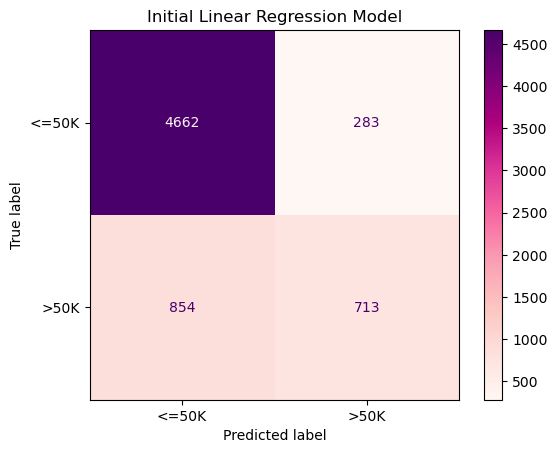

In [101]:
# Print confusion matrix
cm_linreg_init = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=np.unique(y_test),
    cmap=plt.cm.RdPu
)

plt.title('Initial Linear Regression Model')
plt.show()

In [102]:
# Print classification report

print("\n--- Classification Report - Initial Linear Regression Model ---")
print(classification_report(y_test, y_pred))


--- Classification Report - Initial Linear Regression Model ---
              precision    recall  f1-score   support

       <=50K       0.85      0.94      0.89      4945
        >50K       0.72      0.46      0.56      1567

    accuracy                           0.83      6512
   macro avg       0.78      0.70      0.72      6512
weighted avg       0.81      0.83      0.81      6512



### Parameter tuning

In [103]:
# Define the parameter grid to search over
param_grid = {
    'C': np.logspace(-4, 4, 20)
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', 
                                 random_state=42, 
                                 max_iter=500),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

grid_search.fit(X_train, y_train.values.ravel())

# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Linear Regression Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Best Linear Regression Model Found by GridSearchCV ---
Best parameters: {'C': 0.615848211066026}
Best cross-validation accuracy: 0.8258


### Final model

In [104]:
# Re-initialize the model with best parameters
best_model = LogisticRegression(solver='lbfgs', 
                                random_state=42, 
                                max_iter=300,
                                C=grid_search.best_params_['C'])
best_model.fit(X_train, y_train.values.ravel())

# Make predictions on the scaled test set
y_pred_best = best_model.predict(X_test)

In [105]:
# Print accuracy
best_accuracy_linreg = accuracy_score(y_test, y_pred_best)
print(f"Final accuracy on test set: {best_accuracy_linreg:.4f}")

Final accuracy on test set: 0.8254


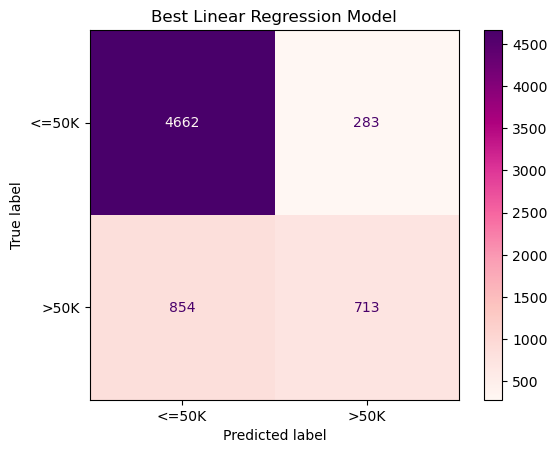

In [106]:
# Print confusion matrix
cm_linreg_best = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=np.unique(y_test),
    cmap=plt.cm.RdPu
)

plt.title('Best Linear Regression Model')
plt.show()

In [107]:
print(y_pred_best)

pd.DataFrame(y_pred_best).to_csv("output/Group_29_LogisticRegression_PredictedOutputs.csv")

['>50K' '<=50K' '<=50K' ... '<=50K' '<=50K' '>50K']


#### Visualize decision boundaries

In [108]:
# Identify most influential features
result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42)

# Print feature importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {data.columns.tolist()[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

Feature education-num: 0.042 +/- 0.001
Feature capital-gain: 0.040 +/- 0.002
Feature sex: 0.009 +/- 0.001
Feature age: 0.009 +/- 0.001
Feature hours-per-week: 0.008 +/- 0.001
Feature capital-loss: 0.007 +/- 0.001
Feature relationship: 0.004 +/- 0.001
Feature marital-status: 0.003 +/- 0.001
Feature workclass: 0.001 +/- 0.000
Feature native-country: 0.001 +/- 0.000
Feature race: 0.001 +/- 0.000
Feature occupation: 0.001 +/- 0.000
Feature fnlwgt: 0.000 +/- 0.000


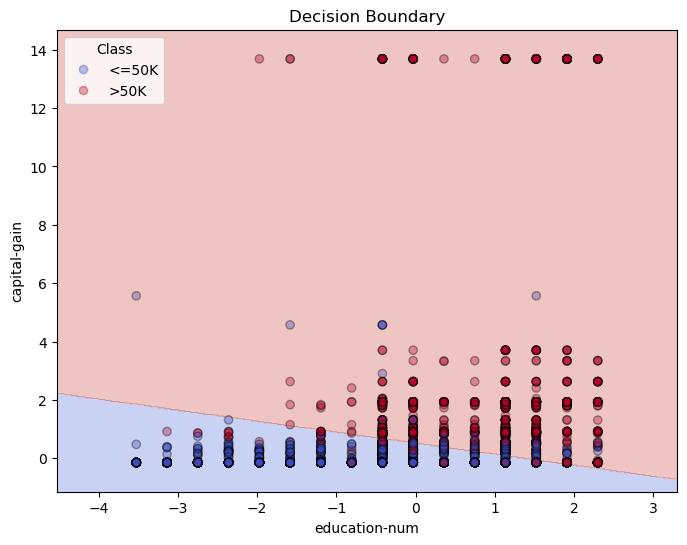

In [109]:
# Select the most influential numeric variables
X_selected = X[['education-num', 'capital-gain']].values
y = y.values.ravel() if hasattr(y, "values") else y

# Fit the model
model = LogisticRegression(solver='lbfgs', 
                                random_state=42, 
                                max_iter=300,
                                C=grid_search.best_params_['C'])
model.fit(X_selected, y)

# Define bounds of the grid
x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                        np.linspace(y_min, y_max, 500))

# Predict across the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Map string labels to numeric
if Z.dtype.type is np.str_ or Z.dtype == object:
    unique_labels = np.unique(Z)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    Z = np.array([label_map[val] for val in Z])

# Reshape for contour
Z = Z.reshape(xx.shape)

# Map string labels in y to numeric if needed
if y.dtype.type is np.str_ or y.dtype == object:
    unique_labels_y = np.unique(y)
    label_map_y = {label: idx for idx, label in enumerate(unique_labels_y)}
    y_numeric = np.array([label_map_y[val] for val in y])
else:
    y_numeric = y

# Plot contour and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter points with colors by class
scatter = plt.scatter(X_selected[:, 0], X_selected[:, 1],
                      c=y_numeric, edgecolors='k', cmap=plt.cm.coolwarm, alpha = 0.35)

# Build legend using mapping
handles, _ = scatter.legend_elements()
labels = [lbl for lbl, idx in sorted(label_map_y.items(), key=lambda x: x[1])]
plt.legend(handles, labels, title="Class")

plt.xlabel('education-num')
plt.ylabel('capital-gain')
plt.title("Decision Boundary")
plt.show()


#### Vary values of C

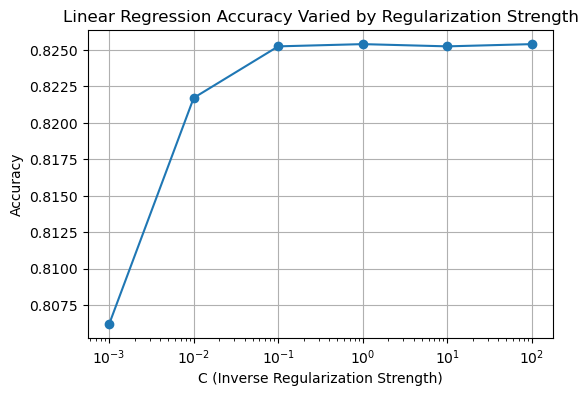

In [110]:
# Values of C to test
C_values = [0.001, 0.01, 0.1, 1.0, 10, 100.0]
accuracies = []

for C in C_values:
    model = LogisticRegression(solver='lbfgs',
                               random_state=42,
                               max_iter=300,
                               C=C)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs C
plt.figure(figsize=(6, 4))
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')  # better visualization since C spans orders of magnitude
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Linear Regression Accuracy Varied by Regularization Strength')
plt.grid(True)
plt.show()

## SVM

### Train initial model

In [111]:
# Train with linear kernel
model = SVC(kernel='linear',
            gamma='auto',
            C=1)
model.fit(X_train, y_train.values.ravel())

# Make predictions on the scaled test set.
y_pred = model.predict(X_test)

#### Evaluate model

In [112]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final accuracy on test set: {accuracy:.4f}")

Final accuracy on test set: 0.8177


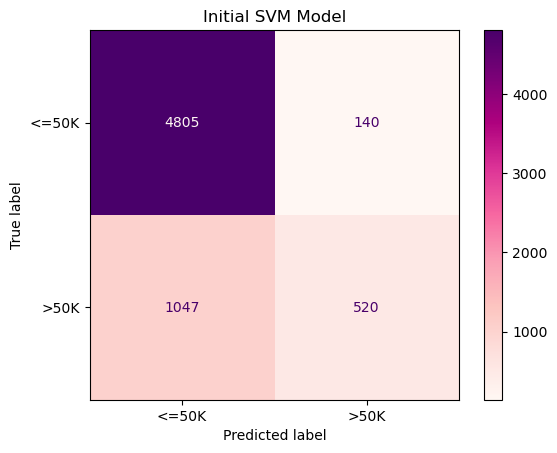

In [113]:
# Print confusion matrix
cm_svm = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=np.unique(y_test),
    cmap=plt.cm.RdPu
)

plt.title('Initial SVM Model')
plt.show()

In [114]:
# Print classification report

print("\n--- Classification Report - Initial SVM Model ---")
print(classification_report(y_test, y_pred))


--- Classification Report - Initial SVM Model ---
              precision    recall  f1-score   support

       <=50K       0.82      0.97      0.89      4945
        >50K       0.79      0.33      0.47      1567

    accuracy                           0.82      6512
   macro avg       0.80      0.65      0.68      6512
weighted avg       0.81      0.82      0.79      6512



### Parameter tuning

In [115]:
# Define the parameter grid to search over.
param_dist = {
    'C': [0.001, 1, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=10,              # try 20 random combinations
    cv=3,                   # 5-fold cross-validation
    scoring='accuracy',     
    n_jobs=-1,              # use all CPU cores
    verbose=1,
    random_state=42
)

print("Starting randomized hyperparameter search...")
random_search.fit(X_train, y_train.values.ravel())

# Best model
best_model = random_search.best_estimator_

print("\n--- Best SVM Found by RandomizedSearchCV ---")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

Starting randomized hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Best SVM Found by RandomizedSearchCV ---
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Best cross-validation accuracy: 0.8438


### Final Model

In [116]:
# Train with linear kernel
best_model = SVC(kernel = random_search.best_params_['kernel'], 
                 gamma = random_search.best_params_['gamma'],
                 C = random_search.best_params_['C'])
best_model.fit(X_train, y_train.values.ravel())

# Make predictions on the scaled test set.
y_pred_best = best_model.predict(X_test)

In [117]:
# Print accuracy
best_accuracy_svm = accuracy_score(y_test, y_pred_best)
print(f"Final accuracy on test set: {best_accuracy_svm:.4f}")

Final accuracy on test set: 0.8398


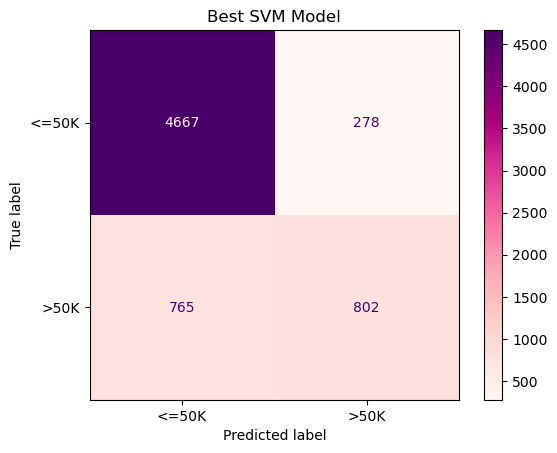

In [118]:
# Print confusion matrix
best_cm_svm = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=np.unique(y_test),
    cmap=plt.cm.RdPu
)

plt.title('Best SVM Model')
plt.show()

In [119]:
print(y_pred_best)

pd.DataFrame(y_pred_best).to_csv("output/Group_29_SVM_PredictedOutputs.csv")

['>50K' '<=50K' '<=50K' ... '<=50K' '<=50K' '>50K']


#### Visualize decision boundaries

In [120]:
# Identify most influential features
result = permutation_importance(best_model, X, y, n_repeats=5, random_state=42)

# Print feature importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {data.columns.tolist()[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

KeyboardInterrupt: 

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


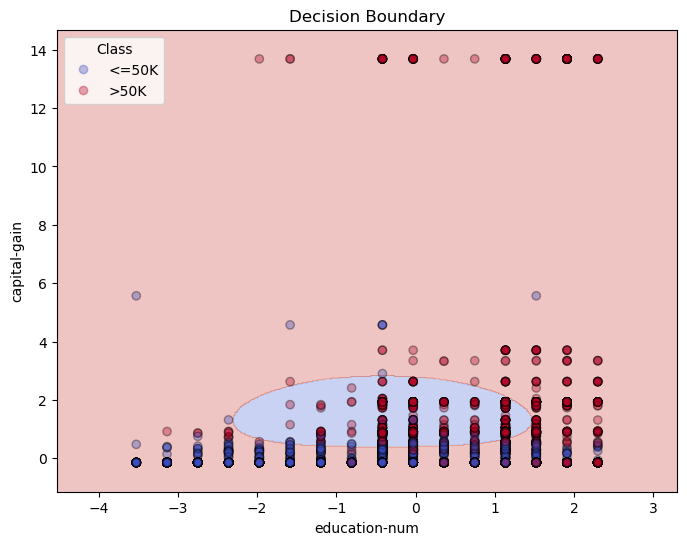

In [124]:
# Select the most influential numeric variables
X_selected = X[['education-num', 'capital-gain']].values
y = y.values.ravel() if hasattr(y, "values") else y

# Fit the model
model = SVC(gamma=random_search.best_params_['gamma'],
            kernel=random_search.best_params_['kernel'],
            random_state=42,
            max_iter=100,
            C=random_search.best_params_['C'])
model.fit(X_selected, y)

# Define bounds of the grid
x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                        np.linspace(y_min, y_max, 500))

# Predict across the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Map string labels to numeric
if Z.dtype.type is np.str_ or Z.dtype == object:
    unique_labels = np.unique(Z)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    Z = np.array([label_map[val] for val in Z])

# Reshape for contour
Z = Z.reshape(xx.shape)

# Map string labels in y to numeric if needed
if y.dtype.type is np.str_ or y.dtype == object:
    unique_labels_y = np.unique(y)
    label_map_y = {label: idx for idx, label in enumerate(unique_labels_y)}
    y_numeric = np.array([label_map_y[val] for val in y])
else:
    y_numeric = y

# Plot contour and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter points with colors by class
scatter = plt.scatter(X_selected[:, 0], X_selected[:, 1],
                      c=y_numeric, edgecolors='k', cmap=plt.cm.coolwarm, alpha = 0.35)

# Build legend using mapping
handles, _ = scatter.legend_elements()
labels = [lbl for lbl, idx in sorted(label_map_y.items(), key=lambda x: x[1])]
plt.legend(handles, labels, title="Class")

plt.xlabel('education-num')
plt.ylabel('capital-gain')
plt.title("Decision Boundary")
plt.show()


#### Vary values of C

/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ruthwalters/miniconda3/envs/ml-class/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ruthw

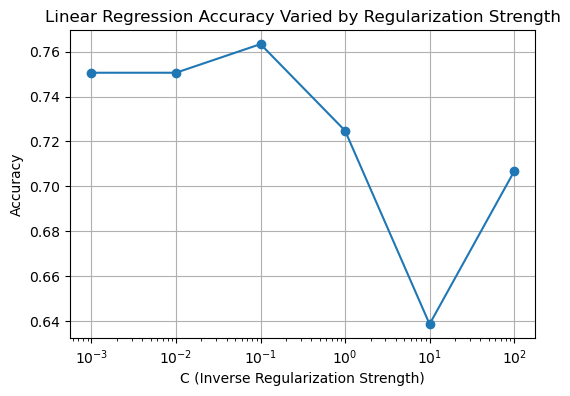

In [125]:
# Values of C to test
C_values = [0.001, 0.01, 0.1, 1.0, 10, 100.0]
accuracies = []

for C in C_values:
    model = SVC(gamma=random_search.best_params_['gamma'],
                kernel=random_search.best_params_['kernel'],
                random_state=42,
                max_iter=300,
                C=C)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs C
plt.figure(figsize=(6, 4))
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')  # better visualization since C spans orders of magnitude
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Linear Regression Accuracy Varied by Regularization Strength')
plt.grid(True)
plt.show()

## Compare models

In [126]:
print("--- Accuracy Evaluation ---")
print(f"Best Linear Regression Accuracy: {best_accuracy_linreg:.4f}")
print(f"Best SVM Accuracy: {best_accuracy_svm:.4f}")

--- Accuracy Evaluation ---
Best Linear Regression Accuracy: 0.8254
Best SVM Accuracy: 0.8398
